In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os, sys

In [2]:
project_root = os.path.abspath("..")  
if project_root not in sys.path:
    sys.path.insert(0, project_root)

### Stochastic Volatility Inspired (SVI)

The SVO parameterization is a practical method to model and smooth implied volatility surfaces, particularly the implied volatility smile or skew seen in options markets. It’s a semi-parametric approach that is simple, arbitrage-free (if handled carefully), and fits real market data well. It was developed by Jim Gatheral in 2004, and the name comes from its inspiration by stochastic volatility models though SVI itself is a deterministic parametric form.

Motivation:
- Market implied volatilities are not flat: Unlike Black-Scholes assumptions, implied volatilities vary with strike and maturity. They form “smiles” and “skews.”
- Raw data is noisy: Option prices across strikes/maturities often contain arbitrage and inconsistencies due to market frictions.
- We need smooth, arbitrage-free volatility surfaces for option pricing, risk management, hedging strategies and model calibration

SVI provides a flexible and stable framework to fit the smiles across different maturities and ensure the full volatility surface is arbitrage-free.

$$w(k) = a + b \left( \rho (k - m) + \sqrt{(k - m)^2 + \sigma^2} \right)$$

Where $w(k)$ is the total implied variance for log-moneyness $k$

Parameters:
- $b > 0$: slope (controls skew)
- $\rho \in (-1, 1)$: skewness
- $m$: horizontal shift (location of smile minimum)
- $\sigma > 0$: controls smile curvature

The steps for this calibration are:
1. Prepare data: compute log-moneyness $k=\log(K/F)$ an the total implied variance $w_{\text{mkt}} = \sigma_{\text{mkt}}^2 \cdot T$
2. Define objective function. We want to find parameters $\theta = (a, b, \rho, m, \sigma)$ such that:

$$\min_{\theta} \sum_{i} \left( w(k_i; \theta) - w_{\text{mkt},i} \right)^2$$
3. Constraints: $b > 0$, $|\rho| < 1$ and $\sigma > 0$. Also we can add penalties to discourange arbitrage.

In [3]:
from volatility_models.svi_calibration import SVICalibrator, generate_synthetic_smile

In [16]:
# Initialize calibrator
calibrator = SVICalibrator(parameterization='raw')

# Generate synthetic market data
strikes, implied_vols = generate_synthetic_smile(
    forward=100.0,
    time_to_expiry=0.25,
    atm_vol=0.20,
    skew=-0.1
)

## Optimisation methodology

For the calibration, the code gives two options:

### 1. Method minimize - Local Optimization
- Algorithm: Uses local optimization methods (BFGS, L-BFGS-B, SLSQP, etc.)
- Strategy: Starts from initial guess and follows gradients to find nearest local minimum
- Speed: Very fast - typically converges in dozens of iterations. Fast convergence when you have a good initial guess
- But can get trapped in local minima!!
  
### 2. Method differential evolution 
- Algorithm: Population-based evolutionary algorithm
- Strategy: Maintains population of candidate solutions, evolves them over many generations
- Speed: Slower - typically needs hundreds to thousands of function evaluations
- Global optimizer - finds global minimum even with multiple local minima (less likey to get stuck)
- Robust to initial conditions (doesn't need good starting guess)

SVI parameter fitting often has multiple local minima, especially when market data is noisy. Recommended approach is the latter.

In [17]:
# Calibrate SVI to market data (using by default differential evolution method)
results = calibrator.calibrate_slice(
    strikes=strikes,
    implied_vols=implied_vols,
    forward=100.0,
    time_to_expiry=0.25,
    #method='L-BFGS-B'
)

print(f"RMSE: {results['rmse']:.6f}")
print(f"R²: {results['r_squared']:.4f}")
print(f"Arbitrage-free: {results['arbitrage_free']}")

RMSE: 0.000068
R²: 0.9990
Arbitrage-free: False


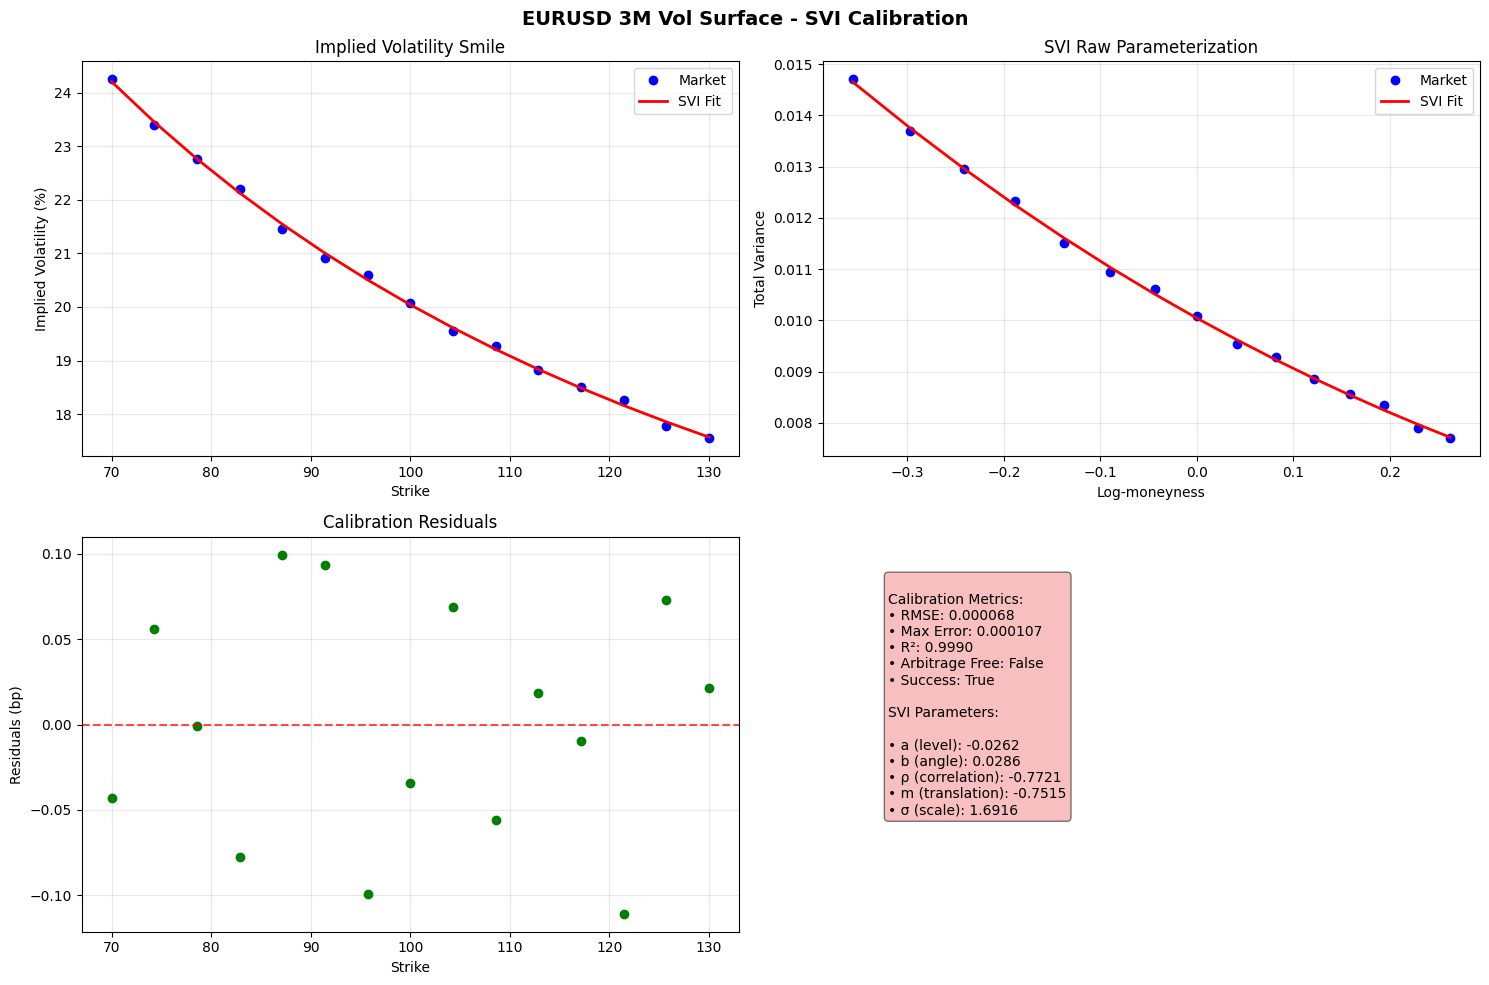

In [18]:
# Plot calibration results
calibrator.plot_calibration_results(
    results,
    title="EURUSD 3M Vol Surface - SVI Calibration"
)